In [4099]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV

In [4100]:
DATASET_NAME = 'zbiór_15.csv'
TARGET_COLUMN = 'default'
RANDOM_STATE = 4
IV_DROP_THRESHOLD = 0.3
CORRELATION_DROP_THRESHOLD = 0.95
TEST_SIZE = 0.2
RANDOM_FORREST_N_ESTIMATORS = 300
WOE_BINS = 20

In [4101]:
data = pd.read_csv(DATASET_NAME)
data.head()

,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,214,6201,8993,112709.98,0.00,0.0,0.0,0.00,0.00,...,0.950530,0.950530,0.052044,0.000000,0.000000,0.000000,0.049470,0.049470,0.950530,1
1,117,214,4110,2607,2369051.57,5063.80,0.0,0.0,5063.80,5063.80,...,0.264511,0.271964,2.780566,0.000000,0.444723,0.444723,0.735489,0.708082,0.262935,1
2,117,215,7022,5868,71925.97,0.00,0.0,0.0,0.00,0.00,...,0.944960,0.944960,0.058246,0.055040,0.000000,0.000000,0.055040,0.055040,0.944960,1
3,117,214,6920,1668,12247.82,0.00,0.0,0.0,0.00,0.00,...,0.774826,0.774826,0.290612,0.225174,0.000000,0.000000,0.225174,0.225174,0.774826,1
4,117,214,6619,1994,614984.31,131077.01,0.0,0.0,118777.01,118777.01,...,0.394975,1.251990,1.531805,0.206732,0.371039,0.371039,0.605025,-0.079497,0.231091,1


In [4102]:
data.describe()

e:\conda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,2957.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.412853,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.063178,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


In [4103]:
list(data.columns)

['szczegolnaFormaPrawna_Symbol',
 'formaWlasnosci_Symbol',
 'pkdKod',
 'wsk_liczba_dni_istnienia',
 'Aktywa',
 'Aktywa_trwale',
 'Wartosci_niematerialne_prawne',
 'Wartosc_firmy',
 'Rzeczowe_aktywa_trwale',
 'Srodki_trwale',
 'Naleznosci_dlugoterminowe',
 'Inwestycje_dlugoterminowe',
 'Rozliczenia_miedzyokresowe_dlugie',
 'Aktywa_obrotowe',
 'Zapasy',
 'Naleznosci_krotkoterminowe',
 'Naleznosci_dostaw_uslug_12m_powiazane',
 'Naleznosci_dostaw_uslug_pow12m_powiazane',
 'Naleznosci_dostaw_uslug_12m_kapitale',
 'Naleznosci_dostaw_uslug_pow12m_kapitale',
 'Naleznosci_dostaw_uslug_12m_pozostale',
 'Naleznosci_dostaw_uslug_pow12m_pozostale',
 'Naleznosci_dostaw_uslug_pozostale_sadowe',
 'Inwestycje_krotkoterminowe',
 'Srodki_pieniezne',
 'Rozliczenia_miedzyokresowe_krotkie',
 'Kapital_wlasny',
 'Kapital_podstawowy',
 'Kapital_zapasowy',
 'Zysk_netto',
 'Zobowiazania_rezerwy',
 'Rezerwy_na_zobowiazania',
 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego',
 'Rezerwa_na_swiadczenia_emerytalne'

In [4104]:
print("Default count: " + str(data[TARGET_COLUMN].value_counts()[1]))
print("No default count: " + str(data[TARGET_COLUMN].value_counts()[0]))

Default count: 159
No default count: 2841


In [4105]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['schemat_wsk_bilans', 'schemat_wsk_rzis'], dtype='object')


In [4106]:
data[categorical_features].head(10)

,schemat_wsk_bilans,schemat_wsk_rzis
0,SFJIN,SFJIN
1,SFJMA,SFJMA
2,SFJMI,SFJMI
3,SFJMI,SFJMI
4,SFJMA,SFJMA
5,SFJIN,SFJIN
6,SFJIN,SFJIN
7,SFJMA,SFJMA
8,SFJIN,SFJIN
9,SFJIN,SFJIN


## Undersample data

In [4107]:
# default_class = data[data[TARGET_COLUMN] == 1]
# no_default_class = data[data[TARGET_COLUMN] == 0]

# no_default_undersampled = no_default_class.sample(n=len(default_class), random_state=RANDOM_STATE)

# balanced_data = pd.concat([default_class, no_default_undersampled])

# data = balanced_data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

## One hot encode categorical features

In [4108]:
one_hot_encoded = pd.get_dummies(data[categorical_features])
data = pd.concat([data, one_hot_encoded], axis=1)
data = data.drop(categorical_features, axis=1)

## Replace NaNs with median

In [4109]:
data = data.fillna(data.median())
data.describe()

e:\conda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.419260,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.050612,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


# Replace inf and -inf with max and min value from column

In [4110]:
missing_columns = ['wsk_plynnosc_biez_1', 'wsk_struktura_kap_wlasnego_s_2', 'wsk_kapital_do_aktywa']

# Replace 'inf' with maximum value and '-inf' with minimum value in each column
for column in missing_columns:
    max_value = data[column].replace([np.inf, -np.inf], np.nan).max()
    min_value = data[column].replace([np.inf, -np.inf], np.nan).min()
    data[column].replace([np.inf, -np.inf], np.nan, inplace=True)
    data[column].fillna(max_value, inplace=True)  # Replace 'inf' with max
    data[column].replace(-np.inf, min_value, inplace=True)  # Replace '-inf' with min

## Remove outliers

In [4111]:
def replace_outliers(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    data_without_outliers = np.clip(column, lower_bound, upper_bound)
    
    return data_without_outliers

numeric_features_no_target = [col for col in numeric_features if col != TARGET_COLUMN]

outliers_num = 0
for column in data[numeric_features_no_target].columns:
    data[column] = replace_outliers(data[column])
    outliers_num += 1

## TODO: Annova

In [4112]:
data.shape

(3000, 224)

In [4113]:
zero_variance_columns = data[numeric_features].columns[data[numeric_features].var()==0]

data.drop(columns=zero_variance_columns, inplace=True)
num_features = [x for x in numeric_features if x in data.columns]

print("Usunięto następujące zmienne o zerowej wariancji: ", zero_variance_columns)

Usunięto następujące zmienne o zerowej wariancji:  Index(['szczegolnaFormaPrawna_Symbol', 'Wartosci_niematerialne_prawne',
       'Wartosc_firmy', 'Naleznosci_dlugoterminowe',
       'Inwestycje_dlugoterminowe', 'Rozliczenia_miedzyokresowe_dlugie',
       'Naleznosci_dostaw_uslug_12m_powiazane',
       'Naleznosci_dostaw_uslug_pow12m_powiazane',
       'Naleznosci_dostaw_uslug_12m_kapitale',
       'Naleznosci_dostaw_uslug_pow12m_kapitale',
       'Naleznosci_dostaw_uslug_pow12m_pozostale',
       'Naleznosci_dostaw_uslug_pozostale_sadowe', 'Rezerwy_na_zobowiazania',
       'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego',
       'Rezerwa_na_swiadczenia_emerytalne',
       'Rezerwa_na_swiadczenia_emerytalne_dlugie',
       'Rezerwa_na_swiadczenia_emerytalne_krotkie', 'Pozostale_rezerwy',
       'Pozostale_rezerwy_krotkie', 'Zobowiazania_dlugoterminowe',
       'Kredyty_pozyczki_dlugie', 'Inne_zobowiazania_fin_dlugoterminowe',
       'Zobowiazania_dostaw_uslug_12m_powiazane',
       '

In [4114]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

annova_test_data = data # pd.concat([data, decision], axis=1)

columns_to_drop = []
for col in data[num_features].columns:
    mod = ols(col + " ~ default", data=annova_test_data).fit()
    aov_table = anova_lm(mod)
    pvalue = aov_table.loc["default","PR(>F)"]
    if(pvalue > 0.05):
        columns_to_drop.append(col)

data.drop(columns=columns_to_drop, inplace=True)
num_features = [x for x in num_features if x in data.columns]

print("Na podstawie testu ANNOVA usunięto następujące zmienne: ", columns_to_drop)

Na podstawie testu ANNOVA usunięto następujące zmienne:  ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_koszt_długu_1', 'wsk_koszt_długu_2', 'wsk_pokrycie_aktywow_tr_kapitalem_st', 'wsk_struktury_finansowania', 'wsk_koszty_fin_przychody', 'wsk_koszty_odsetki_przychody', 'wsk_zadluzenie_gotowka', 'wsk_udzial_kap_wlasnego_aktywa_2', 'wsk_pokrycie_aktywow_kap_stalym', 'wsk_ogolnego_zadluzenia_pozyczki', 'wsk_efekt_dzwigni_fin_2', 'wsk_rotacja_naleznosci_dostaw_uslug', 'wsk_poziom_kosztow_finansowych', 'wsk_rotacja_zobowiazan_dostaw_uslug', 'wsk_plynnosc_biez_1', 'wsk_plynnosc_biez_2', 'wsk_plynnosc_biez_3', 'wsk_plynnosc_szybka_1', 'wsk_plynnosc_szybka_2', 'wsk_plynnosc_gotowkowa_1', 'wsk_udzial_kapitalu_obrotowego_netto', 'wsk_udzial_zob_biez_aktywa_2', 'wsk_udzial_kap_obrotowego_w_fin', 'wsk_zysk_ebitda_1', 'wsk_zysk_ebitda_2', 'wsk_zysk_ebitda_3', 'wsk_struktura_majatku', 'wsk_struktury_kapitalu', 'wsk_zast_kapitalu_wlasnego', 'wsk_zast_kapitalu_stalego', 'wsk_zast_kapitalu_obcego', 'wsk_str

In [4115]:
data.shape

(3000, 134)

## WoE

In [4116]:
def calculate_woe_iv(data, variable, target):
    # Create bins for numerical variables
    if pd.api.types.is_numeric_dtype(data[variable]):
        bins_variable = variable + '_bins'
        data[bins_variable] = pd.qcut(data[variable], q=WOE_BINS, duplicates='drop')

        # Create a table with counts of each category and the count of target = 1
        grouped = data.groupby(bins_variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})
    else:
        # Create a table with counts of each category and the count of target = 1 for non-numeric variables
        grouped = data.groupby(variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})

    # Calculate WOE and IV
    grouped['non_events'] = grouped['total'] - grouped['events']

    # Add a small constant to prevent divide by zero
    eps = 1e-8
    grouped['event_rate'] = (grouped['events'] + eps) / (grouped['events'].sum() + eps)
    grouped['non_event_rate'] = (grouped['non_events'] + eps) / (grouped['non_events'].sum() + eps)

    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    # Sum up the IV values for each category
    iv = grouped['iv'].sum()

    return grouped, iv

In [4117]:
# Calculate WOE and IV for each variable
data_copied = copy.deepcopy(data)

woe_iv_results = []
for column in data.columns:
    if column != TARGET_COLUMN:
        grouped_data, iv = calculate_woe_iv(data_copied, column, TARGET_COLUMN)
        woe_iv_results.append({'Variable': column, 'IV': iv})

# Sort the results by IV in descending order
woe_iv_results = sorted(woe_iv_results, key=lambda x: x['IV'])

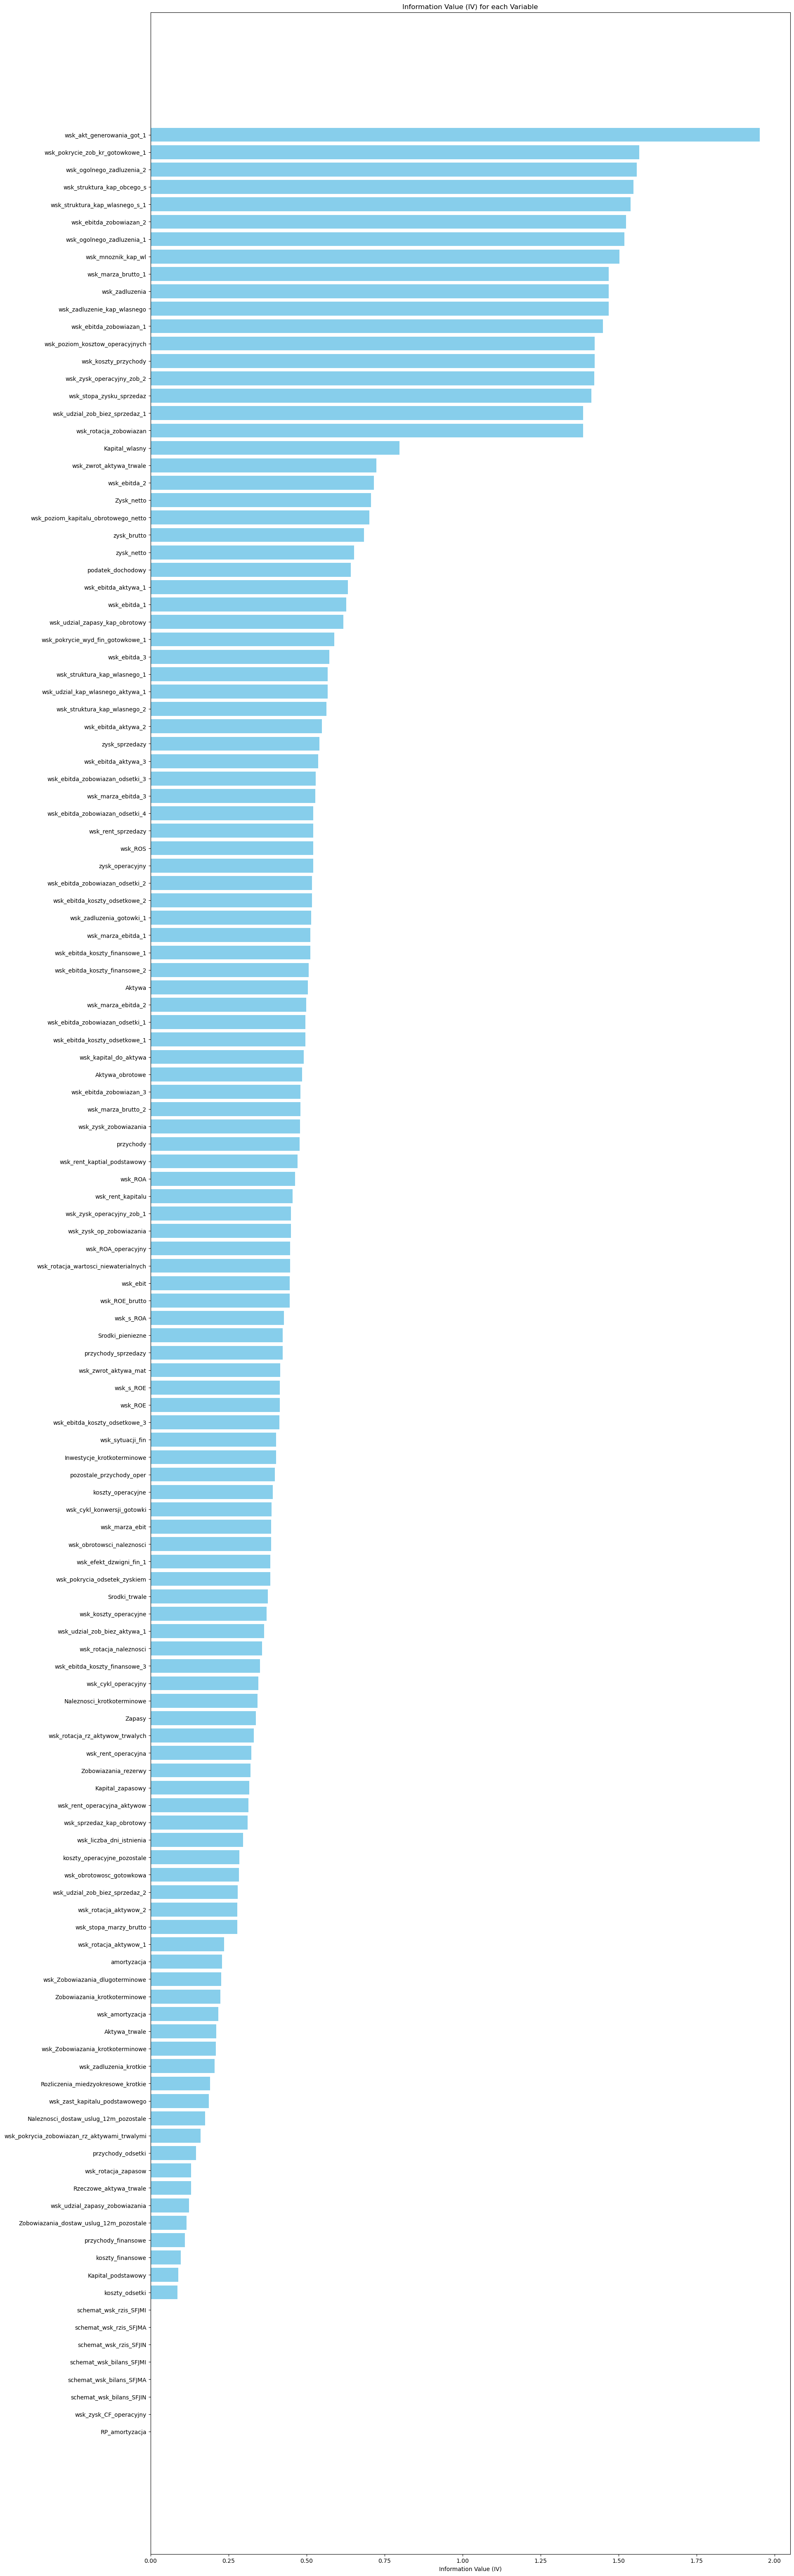

In [4118]:
variables = [result['Variable'] for result in woe_iv_results]
iv_values = [result['IV'] for result in woe_iv_results]

# Create a bar plot
plt.figure(figsize=(20, 80))
plt.barh(variables, iv_values, color='skyblue')
plt.xlabel('Information Value (IV)')
plt.title('Information Value (IV) for each Variable')
plt.show()

## Drop low IV columns (albo od 0.1 albo od 0.3 możemy wywalać)

In [4119]:
print("Number of colums before: " + str(len(data.columns)))
low_iv_columns = [result['Variable'] for result in woe_iv_results if result['IV'] < IV_DROP_THRESHOLD]
data.drop(low_iv_columns, axis=1, inplace=True)
print("Number of colums after: " + str(len(data.columns)))

Number of colums before: 134
Number of colums after: 99


## Drop highly correlated variables, take one with bigger IV

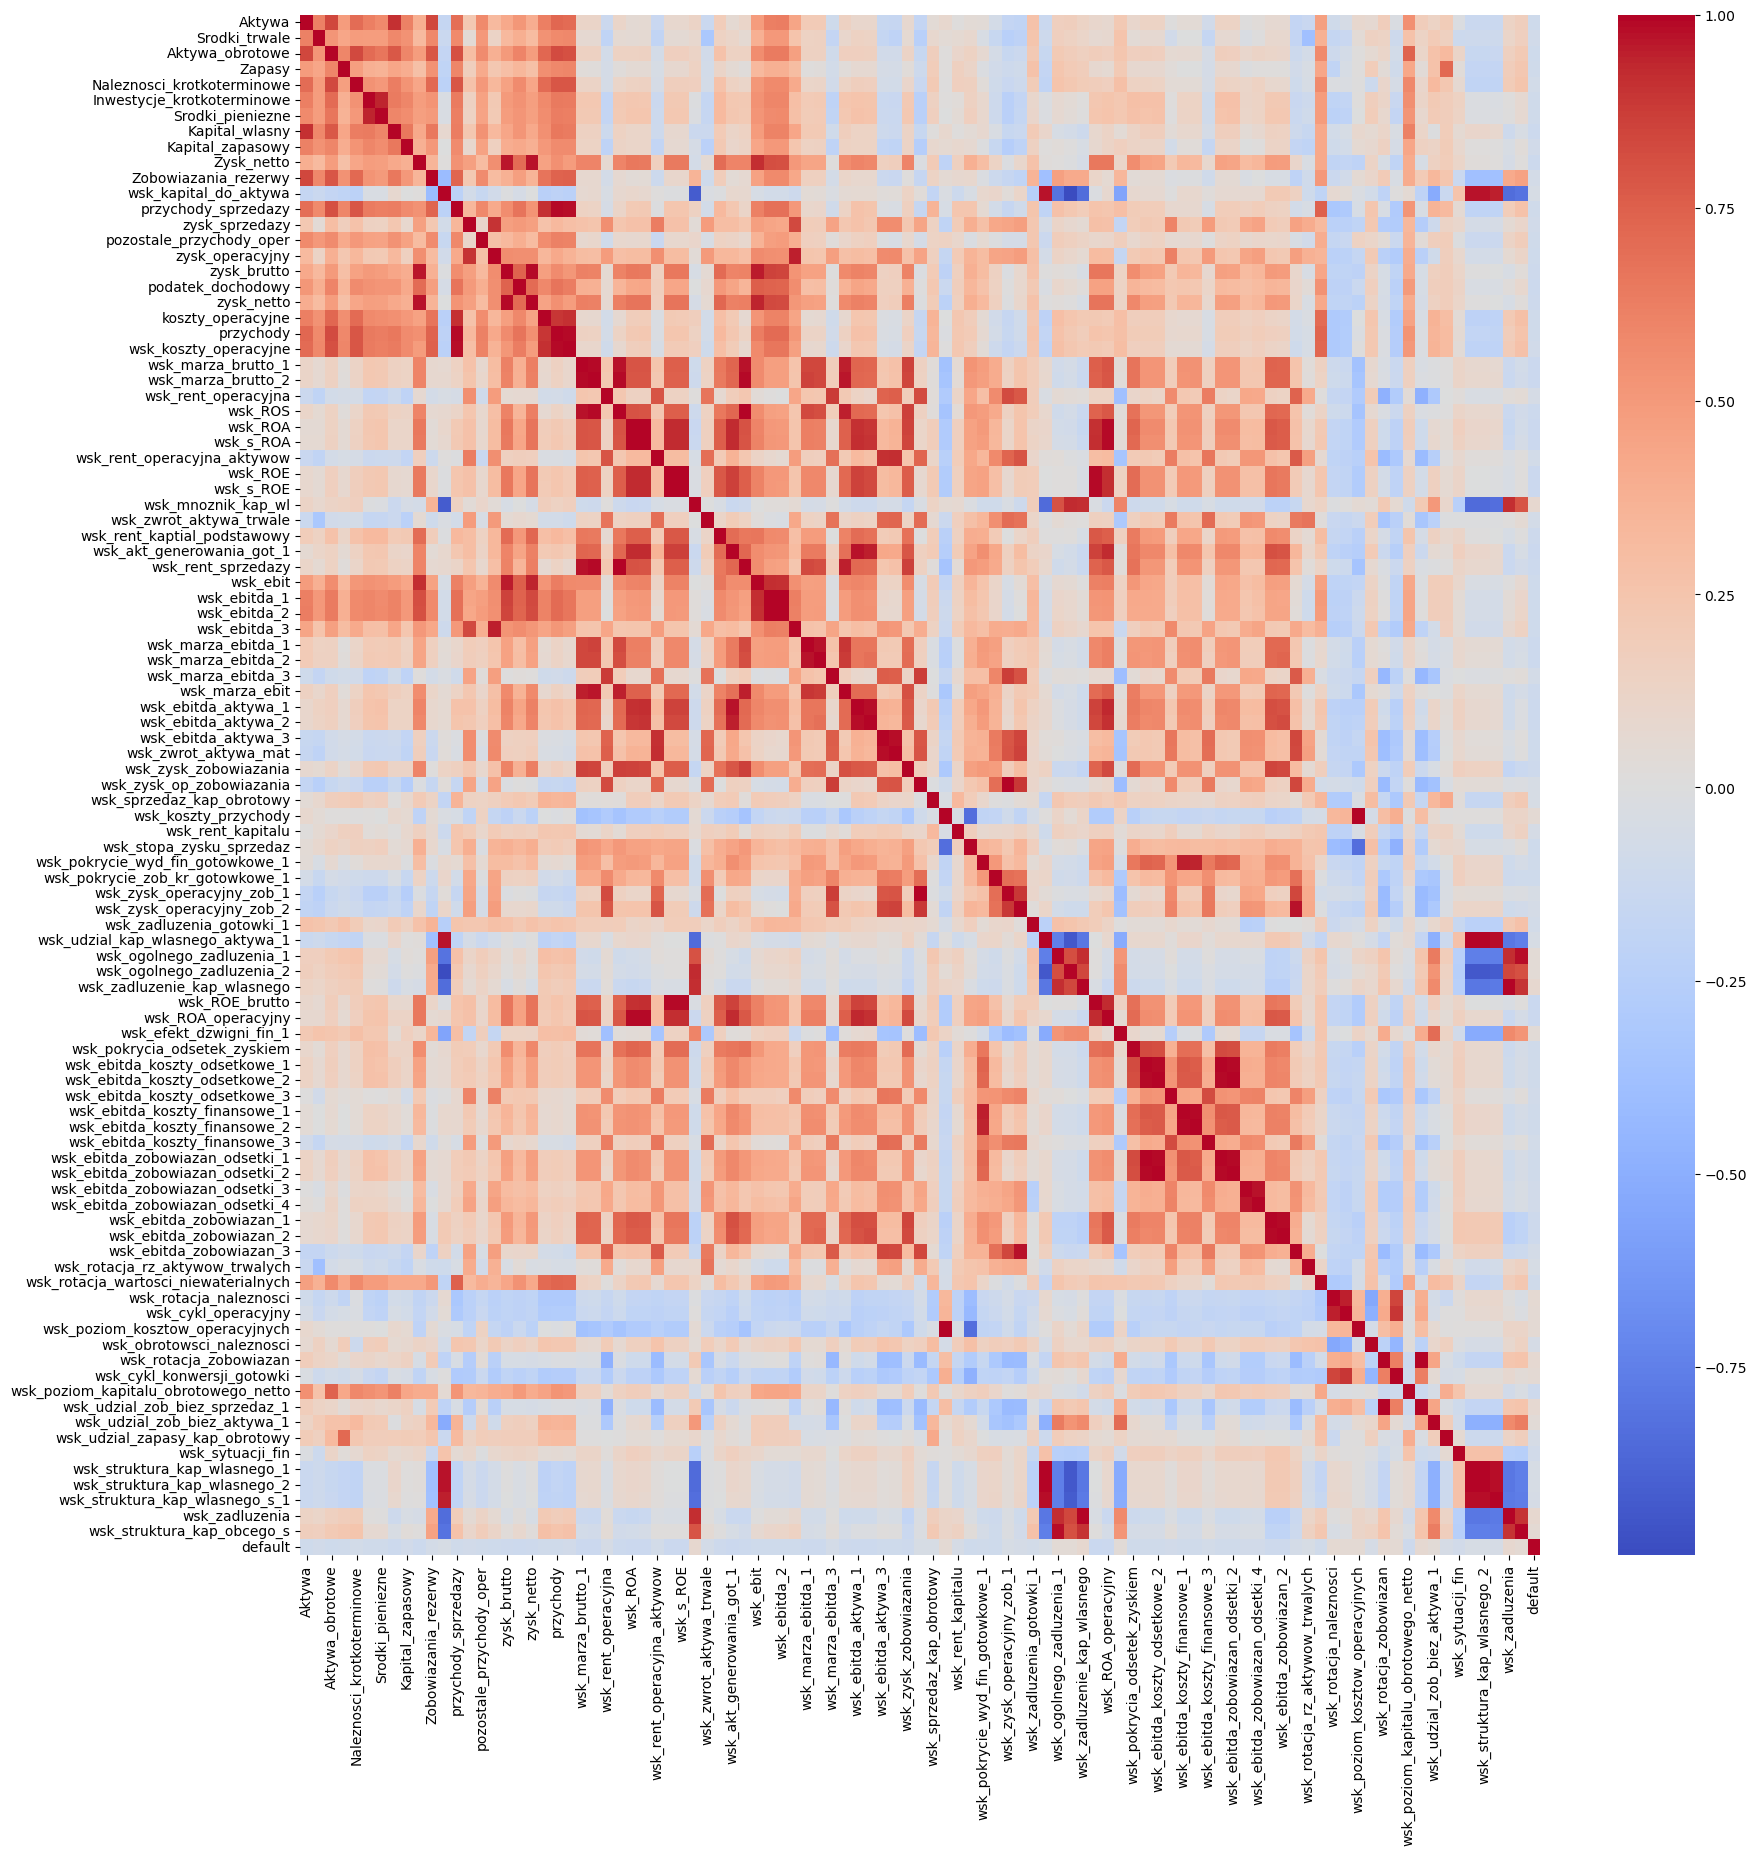

In [4120]:
correlation_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

In [4121]:
print("Number of colums before: " + str(len(data.columns)))

highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > CORRELATION_DROP_THRESHOLD:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(pair)

# Keep variables with higher IV in each pair
for pair in highly_correlated_pairs:
    var1, var2 = pair
    iv_var1 = next(item['IV'] for item in woe_iv_results if item['Variable'] == var1)
    iv_var2 = next(item['IV'] for item in woe_iv_results if item['Variable'] == var2)
    
    if var2 in data.columns and var1 in data.columns:
        if iv_var1 > iv_var2:
            # Keep var1, remove var2
            data = data.drop(var2, axis=1)
        else:
            # Keep var2, remove var1
            data = data.drop(var1, axis=1)

print("Number of colums after: " + str(len(data.columns)))
print("Default count: " + str(data[TARGET_COLUMN].value_counts()[1]))
print("No default count: " + str(data[TARGET_COLUMN].value_counts()[0]))

Number of colums before: 99
Number of colums after: 67
Default count: 159
No default count: 2841


## Uncomment this and set WOE_BINS to > 300 to get Gini = 1

In [4122]:
# for column in data.columns:
#     if column != TARGET_COLUMN:
#         # Calculate WoE and IV for the column
#         grouped, iv_value = calculate_woe_iv(data, column, TARGET_COLUMN)

#         # Create a mapping from bins to WoE values
#         woe_map = grouped['woe'].to_dict()

#         # Apply the WoE mapping to the column
#         bin_column = column + '_bins'
#         data[bin_column] = pd.qcut(data[column], q=WOE_BINS, duplicates='drop')
#         data[column] = data[bin_column].map(woe_map)
#         data.drop(bin_column, axis=1, inplace=True)

# print("Column count: " + str(len(data.columns)))
# print("Default count: " + str(data[TARGET_COLUMN].value_counts()[1]))
# print("No default count: " + str(data[TARGET_COLUMN].value_counts()[0]))
# data.head(20)

In [4123]:
def calculate_auc_gini(y_test, y_pred_prob):
    auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * auc - 1

    return auc, gini

In [4124]:
def plot_feature_importances(model, features, title):
    feature_importances = model.feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 20))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [4125]:
features = data.drop(TARGET_COLUMN, axis=1)
target = data[TARGET_COLUMN]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, stratify=target, random_state=RANDOM_STATE)

In [4126]:
data.head()

,Aktywa,Srodki_trwale,Aktywa_obrotowe,Zapasy,Naleznosci_krotkoterminowe,Inwestycje_krotkoterminowe,Srodki_pieniezne,Kapital_wlasny,Kapital_zapasowy,Zysk_netto,...,wsk_obrotowsci_naleznosci,wsk_rotacja_zobowiazan,wsk_cykl_konwersji_gotowki,wsk_poziom_kapitalu_obrotowego_netto,wsk_udzial_zob_biez_aktywa_1,wsk_udzial_zapasy_kap_obrotowy,wsk_sytuacji_fin,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_obcego_s,default
0,112709.98,0.00,112709.98,0.00,1.127100e+05,0.00,0.00,107134.25,0.00,4959.00,...,0.049241,306.410048,1205.373182,107134.25,0.049470,0.000000,0.192144,0.950530,0.049470,1
1,2369051.57,5063.80,2363987.77,169413.84,1.342365e+06,64928.52,64928.52,626639.43,0.00,95486.70,...,2.300853,134.452050,305.726920,621575.63,0.735489,0.272555,35.068213,0.264511,0.735489,1
2,71925.97,0.00,71925.97,0.00,6.942634e+04,0.00,0.00,67967.17,0.00,0.00,...,0.000000,0.000000,1205.373182,71925.97,0.000000,0.000000,0.171686,0.944960,0.055040,1
3,12247.82,0.00,12247.82,0.00,2.250000e+03,0.00,0.00,9489.93,0.00,0.00,...,25.225874,0.000000,9.354487,12247.82,0.000000,0.000000,0.034410,0.774826,0.225174,1
4,614984.31,118777.01,483907.30,0.00,5.730600e+04,420970.33,420970.33,242903.54,127859.41,15044.13,...,13.073859,119.004714,146.846532,238963.38,0.398293,0.000000,2.410084,0.394975,0.605025,1


In [4127]:
model = RandomForestClassifier(n_estimators=RANDOM_FORREST_N_ESTIMATORS, random_state=RANDOM_STATE)

# Calibrate the classifier using Platt scaling
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
#calibrated_classifier.fit(X_train, y_train)

model.fit(X_train, y_train)

# Train the model
calibrated.fit(X_train, y_train)

# Make predictions on the test set
y_pred = calibrated.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
auc, gini = calculate_auc_gini(y_test, calibrated.predict_proba(X_test)[:, 1])
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {gini:.2f}')
print(report)

Accuracy: 0.94
AUC: 0.71
Gini: 0.43
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       568
           1       0.27      0.09      0.14        32

    accuracy                           0.94       600
   macro avg       0.61      0.54      0.55       600
weighted avg       0.91      0.94      0.92       600



In [4128]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Assuming you have a dataset with features X and target variable y
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a Random Forest classifier
# rf_classifier = RandomForestClassifier()

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='roc_auc', cv=5)

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best model
# best_params = grid_search.best_params_
# best_rf_model = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_rf_model.predict(X_test)
# from sklearn.metrics import roc_auc_score
# # Evaluate the model
# auc = roc_auc_score(y_test, y_pred)
# print(f"Best Parameters (AUC): {best_params_auc}")
# print(f"Test AUC: {auc}")


In [4129]:
# accuracy = accuracy_score(y_test, y_pred)
# auc, gini = calculate_auc_gini(y_test, best_rf_model.predict_proba(X_test)[:, 1])
# report = classification_report(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print(f'AUC: {auc:.2f}')
# print(f'Gini: {gini:.2f}')
# print(report)

In [4130]:
model = RandomForestClassifier(n_estimators=RANDOM_FORREST_N_ESTIMATORS, random_state=RANDOM_STATE)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
auc, gini = calculate_auc_gini(y_test, model.predict_proba(X_test)[:, 1])
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {gini:.2f}')
print(report)

Accuracy: 0.94
AUC: 0.71
Gini: 0.43
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       568
           1       0.00      0.00      0.00        32

    accuracy                           0.94       600
   macro avg       0.47      0.50      0.49       600
weighted avg       0.90      0.94      0.92       600



In [4131]:
scores = cross_val_score(model, features, target, cv=5)
print(scores)

[0.94333333 0.94666667 0.94333333 0.94333333 0.95      ]


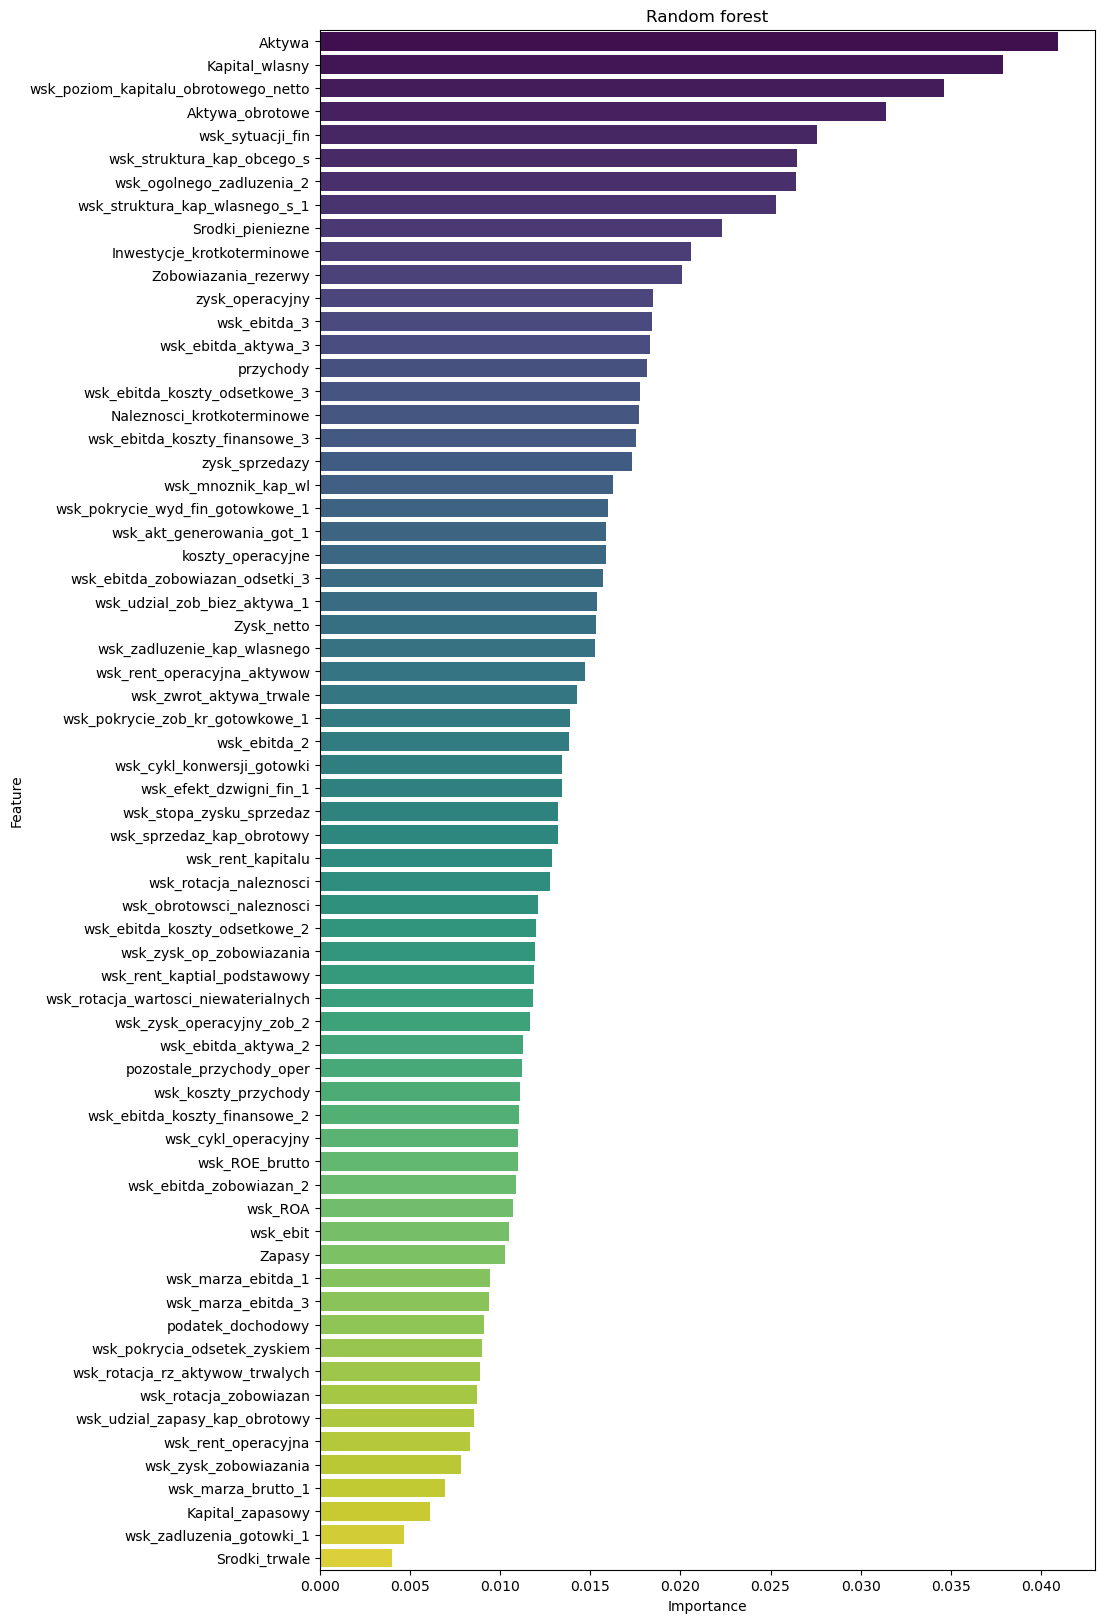

In [4132]:
plot_feature_importances(model, features, "Random forest")

In [4133]:
# Initialize LinearDiscriminantAnalysis classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
auc, gini = calculate_auc_gini(y_test, model.predict_proba(X_test)[:, 1])
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {gini:.2f}')
print(report)

Accuracy: 0.94
AUC: 0.74
Gini: 0.49
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       568
           1       0.25      0.06      0.10        32

    accuracy                           0.94       600
   macro avg       0.60      0.53      0.53       600
weighted avg       0.91      0.94      0.92       600



In [4134]:
scores = cross_val_score(model, features, target, cv=5)
print(scores)

[0.93666667 0.935      0.94333333 0.94166667 0.94      ]
